本文介绍关于使用t-SNE进行可视化, 会使用MNIST作为测试数据集. 因为t-SNE的计算速度比较慢, 所以通常的做法是:

- 首先使用AutoEncoder进行降维, 降低到较低的维度 (例如30维)
- 接着对上面的数据使用t-SNE进行进一步的降维, 来进行可视化.
在这一部分, 我们会首先使用AutoEncoder将MNIST图片降到24维, 接着使用t-SNE进一步进行降维, 并进行可视化.

于是, 这里实验可以分为两个大部分, 分别是训练AE和使用t-SNE进行降维可视化, 下面我们来分开进行介绍.

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
from datetime import date,datetime
import logging

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch import optim
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.utils import save_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
     

device(type='cpu')

In [2]:
def show(img):
    """
    用来显示图片的
    """
    plt.figure(figsize=(12, 8))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
     

# 加载数据

In [3]:
## 训练AutoEncoder
batch_size = 100
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# 定义网络

In [4]:
class DeepAutoEncoder(nn.Module):
    def __init__(self):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=2, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2, inplace=True),
        ) # encoder可以将图片大小转换为 1*28*28 -> 6*2*2
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=4, stride=2, bias=False), # 1->4
            nn.BatchNorm2d(6),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=3, stride=2, bias=False), # 1->4
            nn.BatchNorm2d(6),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=3, stride=2, bias=False), # 4 -> 10
            nn.BatchNorm2d(3),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=2, stride=1, bias=False), # 10 -> 22
            nn.BatchNorm2d(1),
            # nn.Tanh()
        ) # decoder可以将图片大小转换为 6*2*2 -> 1*28*28
    def forward(self, x):
        x = self.encoder(x)
#         print(x.shape) # torch.Size([100, 6, 2, 2])
        x = self.decoder(x)
#         print(x.shape) # torch.Size([100, 1, 28, 28])
        return x

In [6]:
AE = DeepAutoEncoder().to(device) # 定义分类器
# print(AE)
# 进行测试
for i, (datas, labels) in enumerate(train_loader):
    datas = datas.to(device)
#     print(datas.shape) # torch.Size([100, 1, 28, 28])
    x = AE(datas)
    print(x.shape) 
    break

torch.Size([100, 1, 28, 28])


# 开始训练

In [11]:
# 模型的训练. 我们这里使用L1 Loss进行训练, 使用Adam优化器.

# 初始化网络
AE = DeepAutoEncoder().to(device) # 定义分类器

# 定义损失函数
criterion = nn.L1Loss()

# 定义损失函数和优化器
learning_rate = 0.0005
optimizer = torch.optim.Adam(AE.parameters(), lr=learning_rate)
lossList = []

# 开始训练
num_epochs = 20
total_step = len(train_loader) # 依次epoch的步骤
for epoch in range(num_epochs):
    totalLoss = 0 # 总的误差
    for i, (images, _) in enumerate(train_loader):
        batch_size = images.size(0)
        images = images.to(device)
#         print(images.shape)

        # 开始训练discriminator
        AE.train()
        
        # 首先计算真实的图片
        fake_image = AE(images) # 计算重构之后的内容
#         print(fake_image.shape)
        loss = criterion(images, fake_image) # 计算loss
        optimizer.zero_grad() # 优化器梯度都要清0
        loss.backward() # 反向传播
        optimizer.step() # 进行优化
        totalLoss = totalLoss + loss.item()

        # 打印结果
        if (i+2) % 280 == 0:
            t = datetime.now() #获取现在的时间
            print('Time {}, Epoch [{}/{}], Step [{}/{}], loss:{:.4f}'.format(t, epoch, num_epochs, i+1, total_step, totalLoss/(i+1)))
    lossList.append(totalLoss/(i+1))

Time 2023-11-29 13:36:05.125186, Epoch [0/20], Step [279/600], loss:0.2858
Time 2023-11-29 13:36:17.937235, Epoch [0/20], Step [559/600], loss:0.2230
Time 2023-11-29 13:36:32.967460, Epoch [1/20], Step [279/600], loss:0.1440
Time 2023-11-29 13:36:45.592043, Epoch [1/20], Step [559/600], loss:0.1425
Time 2023-11-29 13:36:59.826490, Epoch [2/20], Step [279/600], loss:0.1389
Time 2023-11-29 13:37:12.682583, Epoch [2/20], Step [559/600], loss:0.1356
Time 2023-11-29 13:37:27.220811, Epoch [3/20], Step [279/600], loss:0.1305
Time 2023-11-29 13:37:39.611406, Epoch [3/20], Step [559/600], loss:0.1306
Time 2023-11-29 13:37:54.281673, Epoch [4/20], Step [279/600], loss:0.1303
Time 2023-11-29 13:38:06.940930, Epoch [4/20], Step [559/600], loss:0.1307
Time 2023-11-29 13:38:21.089614, Epoch [5/20], Step [279/600], loss:0.1306
Time 2023-11-29 13:38:33.603865, Epoch [5/20], Step [559/600], loss:0.1307
Time 2023-11-29 13:38:47.771281, Epoch [6/20], Step [279/600], loss:0.1305
Time 2023-11-29 13:39:00.

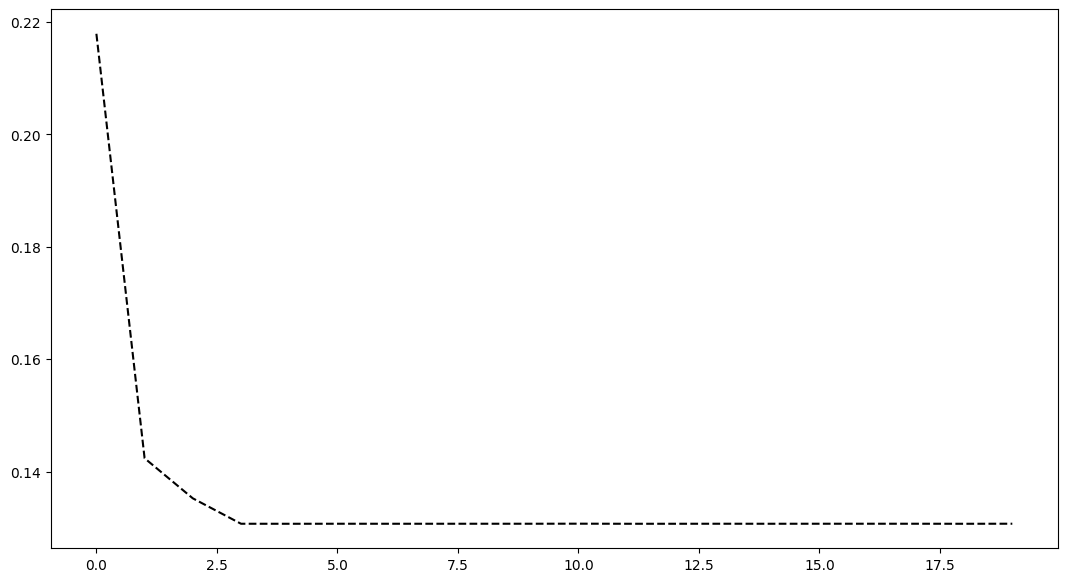

In [12]:
# 绘制loss的变化
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
axes.plot(lossList, 'k--')

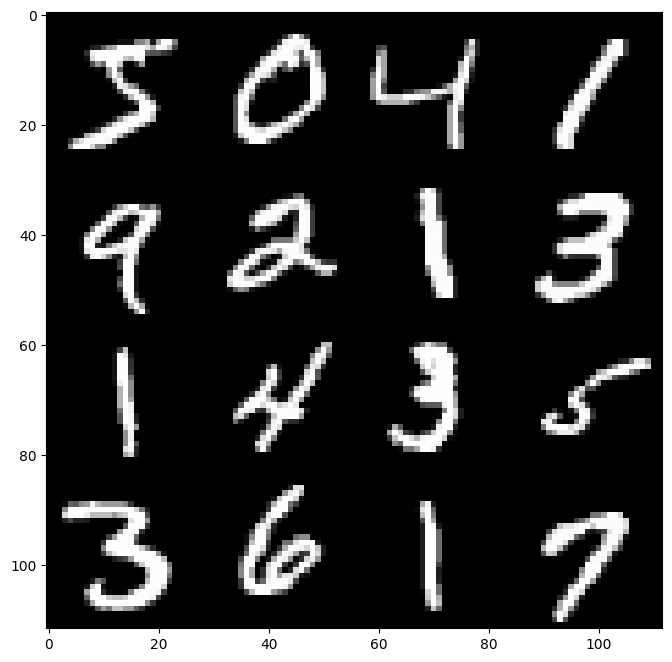

In [18]:
# 首先我们选出16张测试的图片, 并查看原始图片.
# 查看重构的图像
T_images = torch.stack(([train_dataset[i][0] for i in range(16)]))
show(make_grid(T_images, nrow=4, padding=0, normalize=True, range=None, scale_each=False, pad_value=0))

torch.Size([16, 1, 28, 28])


/Users/rl/anaconda3/envs/torch107/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


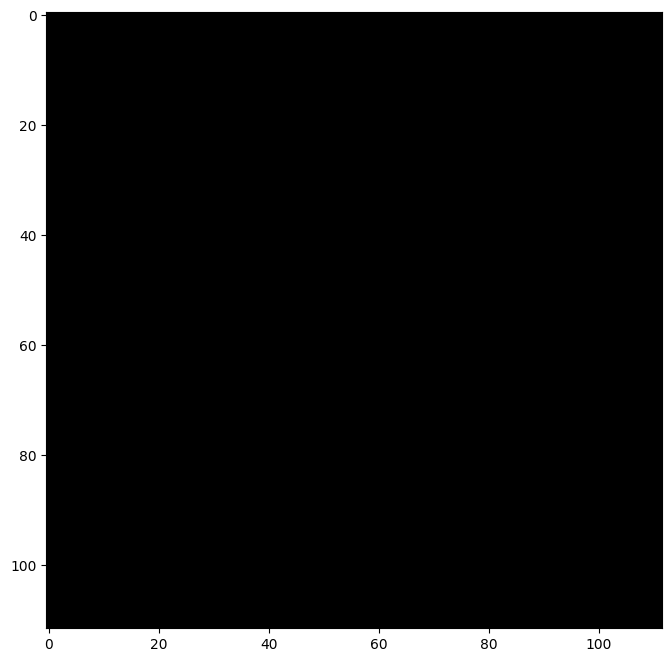

In [26]:
# 查看重构的图片
fake_image = AE(T_images.to(device))
print(fake_image.shape)
show(make_grid(fake_image.cpu().detach(), nrow=4, padding=0, normalize=True, range=None, scale_each=False, pad_value=0))

# 使用t-SNE对encode的输出进行可视化

In [21]:
from sklearn.manifold import TSNE

In [22]:
# 提取数据，因为这里需要接收Numpy的数据, 所以我们需要首先将数据从trainloader中提取出来.

# 进行测试, 生成测试数据
for i, (datas, labels) in enumerate(test_loader):
    batch_size = images.size(0)
    datas = datas.to(device)
    x = AE.encoder(datas)
    x = x.cpu().detach().numpy().reshape(batch_size, -1)
    if i == 0:
        featureList = x # 保存encode之后的特征
        labelsList = labels # 保存对应的label
    else:
        featureList = np.append(featureList, x, axis=0)
        labelsList = np.append(labelsList, labels, axis=0)
    # if i == 3:
    #     break
print(featureList.shape, labelsList.shape)
"""
((10000, 24), (10000,))
"""

(10000, 24) (10000,)


'\n((10000, 24), (10000,))\n'

In [23]:
# 对上面encode之后的结果使用t-SNE进行降维

# 降到2维
x_encode = TSNE(n_components=2).fit_transform(featureList) # 接着使用tSNE进行降维
print(x_encode.shape)
"""
(10000, 2)
"""

(10000, 2)


'\n(10000, 2)\n'

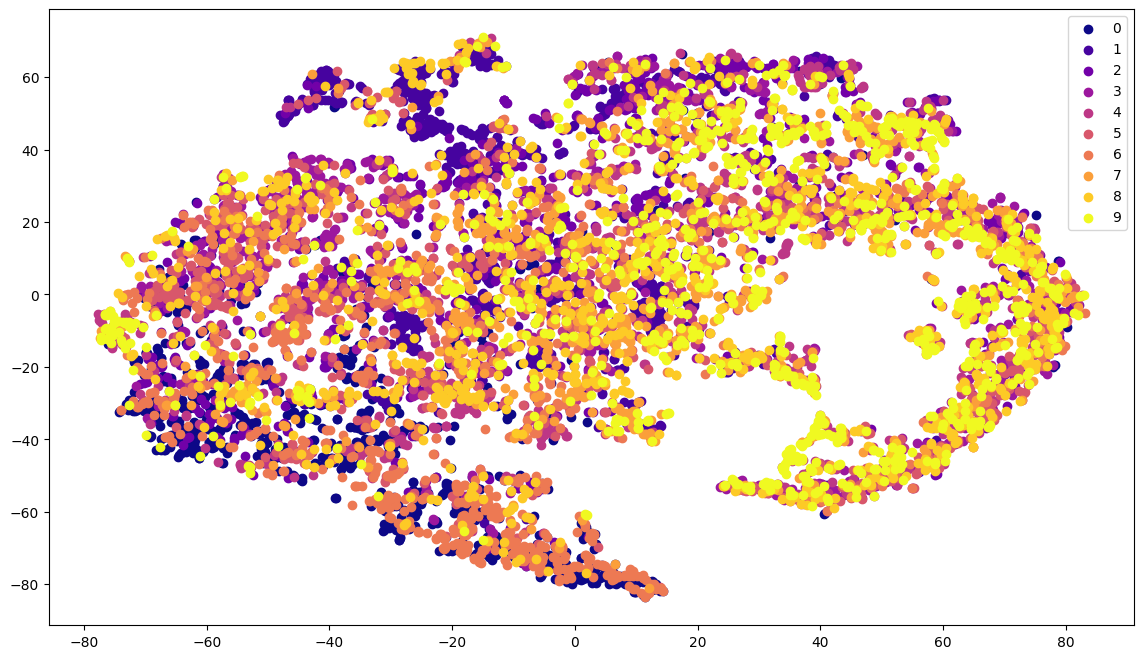

In [24]:
# 进行可视化
cmap = plt.get_cmap('plasma',10) # 数字与颜色的转换

# 获得可视化数据
v_x = x_encode
v_y = labelsList

# 进行可视化
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)

classes = [0,1,2,3,4,5,6,7,8,9]

for key in classes:
    ix = np.where(v_y==key)
    ax.scatter(v_x[ix][:,0], v_x[ix][:,1], color=cmap(key), label=key)
    
ax.legend()
plt.show()

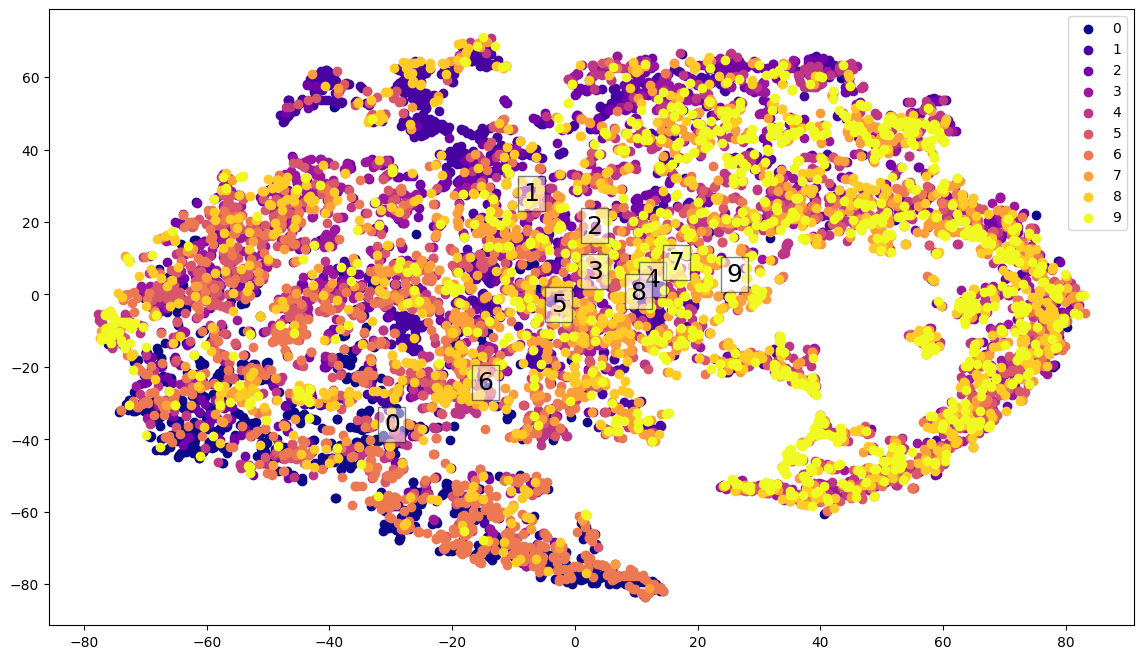

In [25]:
# 进行可视化
cmap = plt.get_cmap('plasma',10) # 数字与颜色的转换

# 获得可视化数据
v_x = x_encode
v_y = labelsList

# 进行可视化
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)

classes = [0,1,2,3,4,5,6,7,8,9]

for key in classes:
    ix = np.where(v_y==key)
    ax.scatter(v_x[ix][:,0], v_x[ix][:,1], color=cmap(key), label=key)
    ax.text(np.mean(v_x[ix][:,0]), np.mean(v_x[ix][:,1]), key, fontsize=18, bbox=dict(facecolor='white', alpha=0.5))
    
ax.legend()
plt.show()